# Session 7: Supervised Machine Learning (classification) 

In this guide we will perform traditional text classification using sparse text representations (TF-IDF) vectors
We will also examine image classification 
We will use the same set of models for both. 

### Data loading and preprocessing: text
We will be loading a corpus of Amazon reviews **labeled** for sentiment (positive or negative)


In [1]:
# importing the Python's Pandas library for data loading and manipulation
import pandas as pd

# Step #1: loading our annotated reviews
train_data = pd.read_csv('reviews_train.csv', delimiter = '\t') # in our file, the values are actually TAB-separated
eval_data = pd.read_csv('reviews_test.csv', delimiter = '\t')

# let's see what our data actually looks like
print(train_data)
#print(train_data.count()) #note: size training
#print(eval_data.count()) #note: size eval

     label  score                                            content
0      NEG    2.0   cons tips extremely easy on carpet and if you...
1      NEG    1.0   It's a nice look, but it tips over very easil...
2      NEG    1.0   I have bought and returned three of these uni...
3      NEG    1.0   I knew these were inexpensive CD cases, but I...
4      NEG    2.0   I used a 25 pack of these doing DVD backups, ...
...    ...    ...                                                ...
1795   POS    5.0   I just recieved my HDMI cable and am very imp...
1796   POS    5.0   This is the perfect keyboard ( I know cuz I a...
1797   POS    5.0   SanDisk has done it again. They never seem to...
1798   POS    5.0   Fast shipping, Very happy with the GARMIN. Th...
1799   POS    5.0   The SanDisk 1GB Micro SD Card arrived quickly...

[1800 rows x 3 columns]



 **SpaCy** (https://spacy.io/) is a library that offers a lot of functionality for text processing and many pretrained NLP models: 
 - tokenization
 - POS-tagging 
 - Syntactic parsing
 - Named entity recognition, 
 - and many more...

In [2]:
# let us preprocess (tokenize and lemmatize) the texts
# install spacy with pip or conda, e.g., pip install spacy
import spacy

# wordcloud library displays texts as word clouds, based on word frequency statistics
import wordcloud

# wordcloud has its own list of STOPWORDS
from wordcloud import STOPWORDS

# removing the repetitions if there are any, converting the list to set
stopwords = set(list(STOPWORDS) + ['.', "?", "!", ",", "(", ")", ":", ";", "\"", "'"])
print(stopwords)



{'should', "aren't", 'against', 'have', 'while', "you're", 'with', 'not', "you'd", "we're", 'and', 'else', 'did', "it's", 'by', 'just', '!', 'between', 'http', "we'd", 'too', 'as', "isn't", "i'll", "he'll", 'further', 'i', 'no', 'again', 'ever', 'him', 'those', 'where', 'above', 'since', "doesn't", ';', 'before', 'doing', 'get', "wasn't", 'himself', 'there', 'cannot', "hadn't", 'until', 'you', 'then', 'r', "they'll", 'in', 'few', "don't", 'most', 'their', 'your', 'nor', 'on', 'does', 'otherwise', 'which', 'was', 'her', 'some', "who's", 'themselves', 'they', 'www', 'having', "i've", "when's", 'could', 'been', "how's", 'through', "he's", 'very', 'them', "you've", 'yourself', 'after', 'so', 'these', 'under', 'up', "wouldn't", 'k', 'yourselves', 'more', 'any', 'is', 'how', 'he', "they'd", "shan't", 'hers', '.', "that's", "he'd", "let's", '(', 'at', 'who', 'myself', 'for', 'hence', 'therefore', 'theirs', 'each', 'herself', 'itself', 'to', '?', 'shall', 'what', 'can', "you'll", 'do', "i'm", 

When we preprocess text for text classification, we often: 
- Remove stopwords (like "a", "the", "of", "in", "and")
- Lemmatize words (reduce different forms of the same word to a common form: houses -> house)


In [3]:
# The model we want to load needs to be first downloaded: 
# in command line: python -m spacy download en_core_web_sm
# load the spacy models for English
nlp = spacy.load("en_core_web_sm") #download module first

train_data["tokens"] = train_data.content.apply(lambda x: [t.lemma_.lower() for t in nlp(x, disable=["parser", "ner"]) if (t.text.strip() != "" and (t.text.lower() not in stopwords))]) #lemma reduces word case to nominative
eval_data["tokens"] = eval_data.content.apply(lambda x: [t.lemma_.lower() for t in nlp(x, disable=["parser", "ner"]) if (t.text.strip() != "" and (t.text.lower() not in stopwords))])

train_data
#doesnt work: remove tagger in line 6 and 7 -> ex: disable=["tagger", "parser", "

,label,score,content,tokens
0,NEG,2.0,cons tips extremely easy on carpet and if you...,"[con, tip, extremely, easy, carpet, lot, cd, s..."
1,NEG,1.0,"It's a nice look, but it tips over very easil...","[be, nice, look, tip, easily, steady, rug, sur..."
2,NEG,1.0,I have bought and returned three of these uni...,"[buy, return, three, unit, now, one, defective..."
3,NEG,1.0,"I knew these were inexpensive CD cases, but I...","[know, inexpensive, cd, case, can, not, even, ..."
4,NEG,2.0,"I used a 25 pack of these doing DVD backups, ...","[use, 25, pack, dvd, backup, last, 5, failed, ..."
...,...,...,...,...
1795,POS,5.0,I just recieved my HDMI cable and am very imp...,"[recieve, hdmi, cable, impressed, price, $, 5,..."
1796,POS,5.0,This is the perfect keyboard ( I know cuz I a...,"[perfect, keyboard, know, cuz, type, right, no..."
1797,POS,5.0,SanDisk has done it again. They never seem to...,"[sandisk, do, never, seem, let, product, marke..."
1798,POS,5.0,"Fast shipping, Very happy with the GARMIN. Th...","[fast, shipping, happy, garmin, tech, support,..."


## Traditional text classification 

### Converting texts into TF-IDF sparse vectors

- To this end we will use the existing functionality (TF-IDF vectorizer) from the Scikit-Learn library
- One could alternatively also use the CountVectorizer (as we did for in Session 6)

We have already seen the Scikit-Learn library in Python the last time. It offers many machine learning (but also text processing) methods, models, and tools that can be used out of the box with a very consistent and uniform API (same functions, like fit, transform, fit_transform, ...)

In [4]:
# we will use the sklearn library for text preprocessing (and later also for classification and clustering algorithms/models)
import sklearn

# for this we need the TfidfVectorizer class from scikit-learn (sklearn) 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer #note: high idf, if word appears more often

# dummy function, returning our already tokenized text. TfidfVectorizer usually expects raw text and performs tokenization of
# its own. Since we already tokenized the texts ourselves with SpaCy, we just provide those tokens
def dummy(tokenized_text):
    return tokenized_text

# Converting Pandas data series into a list of tokenized texts (input format required by scikit-learn's TfidfVectorizer)
train_set = train_data["tokens"].tolist()
eval_set = eval_data["tokens"].tolist()

# initializing the TF-IDF vectorizer
vectorizer = TfidfVectorizer(tokenizer = dummy, preprocessor = dummy)

# vectorizer learns the vocabulary from the (tokenized) train set tweets
vectorizer.fit(train_set) #fit builds the vocabulary

# let's see what the vocabulary looks like
print(vectorizer.vocabulary_)

print()

# let's see how many different words we have in our vocabulary
print(len(vectorizer.vocabulary_))

#personal note: find max
print(max(vectorizer.vocabulary_.values()))
print(max(vectorizer.vocabulary_.keys()))

#note: output example "con" with position 2105 etc. 

{'con': 2105, 'tip': 8176, 'extremely': 3334, 'easy': 2987, 'carpet': 1763, 'lot': 5007, 'cd': 1798, 'stack': 7637, 'top': 8210, 'poorly': 6230, 'design': 2590, 'vertical': 8703, 'rack': 6559, 'not': 5649, 'individual': 4396, 'slot': 7431, 'want': 8823, 'bottom': 1541, 'basically': 1329, 'pull': 6468, 'whole': 8937, 'put': 6488, 'together': 8193, 'pain': 5943, 'one': 5780, 'buy': 1658, 'break': 1563, 'piece': 6135, 'metal': 5248, 'fit': 3509, 'guide': 3937, 'hole': 4140, '..': 69, '...': 70, 'even': 3206, 'well': 8902, 'gap': 3757, 'casse': 1781, 'loose': 4998, 'fitting': 3511, 'pro': 6357, '..........': 77, 'guess': 3935, 'hold': 4138, '....': 71, 'be': 1347, 'nice': 5603, 'look': 4993, 'easily': 2984, 'steady': 7674, 'rug': 7010, 'surface': 7875, 'dispite': 2744, 'picture': 6132, 'box': 1547, 'show': 7315, 'advice': 848, 'need': 5550, "'s": 10, 'save': 7094, 'money': 5390, 'invest': 4554, 'something': 7503, 'sturdy': 7768, 'return': 6897, 'three': 8126, 'unit': 8501, 'now': 5673, 'de

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [5]:
# Step 2: Create TF-IDF vectors for train set and evaluation set reviews, convert the "string" labels into numeric labels

# Creating now TF-IDF vectors for train set, and then for evaluation set
train_tfidf_vectors = vectorizer.transform(train_set)
eval_tfidf_vectors = vectorizer.transform(eval_set)

# let's see what the TF-IDF vectors of training set tweets look like
print("Train set TF-IDF vectors")
print(train_tfidf_vectors.shape)
print()
print(train_tfidf_vectors)

#output: shows only the position of non-zeros

Train set TF-IDF vectors
(1800, 9173)

  (0, 8937)	0.10102057390137142
  (0, 8902)	0.04569912536166878
  (0, 8823)	0.06170195607024618
  (0, 8703)	0.1494719003287464
  (0, 8210)	0.08582608188389235
  (0, 8193)	0.10294638971407037
  (0, 8176)	0.11015328249762119
  (0, 7637)	0.3818207709833976
  (0, 7431)	0.10921330964371818
  (0, 6559)	0.139150273973618
  (0, 6488)	0.07225819490186158
  (0, 6468)	0.0947536539717236
  (0, 6357)	0.09430955318215681
  (0, 6230)	0.21842661928743637
  (0, 6135)	0.08312797693921625
  (0, 5943)	0.11015328249762119
  (0, 5780)	0.04355835249477955
  (0, 5649)	0.07448794660146939
  (0, 5248)	0.12146075181154553
  (0, 5007)	0.14222292079897825
  (0, 4998)	0.11564791329529184
  (0, 4396)	0.12965348755389228
  (0, 4140)	0.11834601823996795
  (0, 4138)	0.07544680706589965
  (0, 3937)	0.12321888390231862
  :	:
  (1799, 3615)	0.06044989493160704
  (1799, 3533)	0.06633285438301216
  (1799, 3468)	0.05106373915206322
  (1799, 3274)	0.16592083291278847
  (1799, 3131)	0.125

In [6]:
# Converting labels "POS" and "NEG" into numeric labels, as required by the logistic regression classifier

# for the train set (trains the logistic regression)
train_labels = train_data["label"].tolist() #always create a list via .tolist() => makes it easier to observe
train_labels = [(1 if tl == "POS" else 0) for tl in train_labels]

# for the evaluation set
eval_labels = eval_data["label"].tolist()
eval_labels = [(1 if el == "POS" else 0) for el in eval_labels]

# let's see what the TF-IDF labels of training set tweets look like
print("Train set labels")
print(train_labels)
print()
print("Test set labels")
print(eval_labels)


print(len(train_labels))
print(train_tfidf_vectors.shape[0])

Train set labels
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### Model training (logistic regression) and evalution

In [17]:
# Step 3: Train the logistic regression classifier on the training set

# For this we need the LogisticRegression class 
from sklearn.linear_model import LogisticRegression

# we now train ("fit") the logistic regression classifier by providing the training input (tf-idf vectors of train tweets) and 
# corresponding offensiveness labels for those tweets
classifier = LogisticRegression(C = 32, solver = 'lbfgs') #c for pruning (= against overfitting), default c = 1.0
classifier.fit(train_tfidf_vectors, train_labels)

# the result is a trained classifier, which we can examine more closely in the next steps and make predictions with
print(classifier)

LogisticRegression(C=32)


In [18]:
# Step 4: Let's evaluate the accuracy of our classifier on evaluation tweets
# for this we can directly use the "score" function of the LogisticRegression classifier
accuracy = classifier.score(eval_tfidf_vectors, eval_labels)
print("Classification accuracy: " + str(accuracy * 100) + "%")
#note: for different results change the c in column above

Classification accuracy: 85.5%


In [9]:
classifier.coef_[0]

array([-0.30966687, -0.30966687, -0.30966687, ..., -0.22639049,
       -0.38358932,  1.35579177])

In [23]:
# Step 5: Intepretability of the classifier: analysis of weights assigned to individual terms

# let's build a dictionary with words from our vocabulary as keys and their associated weights 
# (produced by the LogisticRegression) classifier as values

# initialize the empty dictionary
weights_dict = {}

# for each term in the "vectorizer.vocabulary_" (dict that maps terms to IDs)
for term in vectorizer.vocabulary_:
    # we add that term and look up the LR weight at the corresponding ID
    weights_dict[term] = classifier.coef_[0][vectorizer.vocabulary_[term]] #coef[0] at position=index of the term

# let's sort terms according to their LR weights, from lowest (largest negative values) to highest (largest positive values) 
weights_sorted = list(sorted(weights_dict.items(), key=lambda item: item[1])) #note: lambda is necessary

# 20 terms with smallest weights (most indicative of the 0 class: "not offensive")
#print(weights_sorted[:100])

weights_sorted.reverse()
#output: negative values have the lowest weight, in this case use following code (without reverse)
#weights_sorted

#print()
print(weights_sorted[:100])


#word = "fragile"
#word_w = classifier.coef_[0][vectorizer.vocabulary_[word]]
#print(word + ": " + str(word_w))




[('great', 9.575495327954993), ('excellent', 8.103151645052478), ('price', 7.736031272641112), ('perfect', 7.377469269205877), ('highly', 6.8288041533703625), ('good', 6.6356784539805815), ('fast', 6.621491748404619), ('allow', 6.47182393025674), ('memory', 6.392839005798289), ('use', 5.85237879498952), ('movie', 5.348078097564736), ('easy', 5.1266024710194715), ('happy', 4.983530526397363), ('fantastic', 4.752451798838538), ('clear', 4.713011631469344), ('comfortable', 4.586802375970739), ('little', 4.563646992793037), ('want', 4.559771921164016), ('g', 4.553685928498685), ('pretty', 4.501070694801781), ('amazing', 4.490686362084374), ('bit', 4.3150384434407965), ('worth', 4.220283079855858), ('glad', 4.216787294628772), ('lot', 4.186413270012008), ('value', 4.076667848029703), ('without', 4.072605302000999), ('awesome', 4.067667561427626), ('perform', 4.038353026820253), ('extra', 4.003623550952014), ("'ve", 3.9849987106119755), ('output', 3.870035841216675), ('complain', 3.858268892

In [26]:
word = "fragile"
word_w = classifier.coef_[0][vectorizer.vocabulary_[word]]
print(word + ": " + str(word_w))

fragile: -0.7421316457940917


In [31]:
# new texts
new_texts = ["I love this device"]
#new_texts = ["I love this device", "This is the worst MP3 I've ever seen..."]

# tokenization & lemmatization of new texts
new_texts_tokenized = [[t.lemma_.lower() for t in nlp(x, disable=["tagger", "parser", "ner"]) if (t.text.strip() != "" and (t.text.lower() not in stopwords))] for x in new_texts]

print(new_texts_tokenized)

tf_idf_feats = vectorizer.transform(new_texts_tokenized)
print(tf_idf_feats)

print(classifier.predict(tf_idf_feats))
print(classifier.predict_proba(tf_idf_feats))

#probs: 1st negative, 2nd positive (neg + pos show if a review is more positive or more negative according to its probability)

[['love', 'device']]
  (0, 5016)	0.7237647834237045
  (0, 2623)	0.690046765281628
[1]
[[0.08723331 0.91276669]]


### Data loading and preprocessing: images
We will be loading a collection of images of handwritten digits (MNIST)

Keras is a library for deep learning, but we will just use it to load the MNIST dataset of images from it. You will have to install both keras and tensorflow libraries 

- pip install tensorflow
- pip install keras


60000 10000
(28, 28)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0

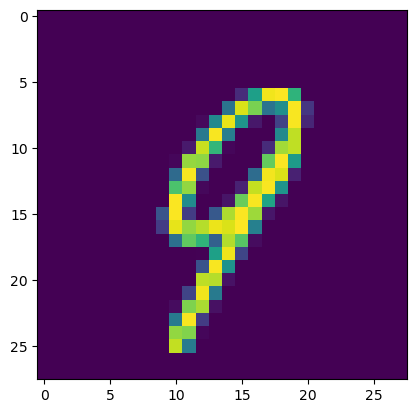

In [32]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Loading the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

print(len(X_train), len(X_test))

X_train = X_train.astype('float32') / 255. #to get the number between 0 and 1 devide the value by 255 (max color value)
X_test = X_test.astype('float32') / 255.


print(X_train[0].shape)

print(X_train[22])
print(y_train[22])

plt.imshow(X_train[22])

In [61]:
# let's train the same classification algorithm as for text classification
# logistic regression
from sklearn.linear_model import LogisticRegression

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:]))) #LR requires a vector not a matrix, so we have to reshape it
print(X_train.shape)
# 60000 instances with 784 features each is a big dataset to train logistic regression

# reduce to 10000 examples
X_train = X_train[:10000]
y_train = y_train[:10000]

classifier = LogisticRegression(C=1)#(C = 1, solver = 'lbfgs')
classifier.fit(X_train, y_train)

(1000, 784)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1)

In [57]:
#instead of 1 weight as for texts, for pictures we have 1 pixel
print(len(classifier.coef_)) #all classes
print(len(classifier.coef_[3])) #class 3

10
784


In [60]:
# let's score its performance on the evaluation set

X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:]))) 

accuracy = classifier.score(X_test, y_test)
print("Classification accuracy: " + str(accuracy * 100) + "%")

Classification accuracy: 86.53999999999999%


In [64]:
# we can do exactly the same thing: training + prediction/evaluation with a different classifier -- SVM

from sklearn.svm import SVC 

# initialize classifier
classifier = SVC(C = 1, kernel = "rbf") #kernel="linear" is faster but not as accurate as rbf

# train classifier
classifier.fit(X_train, y_train)

# predict and evaluate classifier
accuracy = classifier.score(X_test, y_test)
print("Classification accuracy: " + str(accuracy * 100) + "%")

Classification accuracy: 90.83%


In [ ]:
#LG: if you have more zeros
#SVM: 